### Imports

In [ ]:
%load_ext autoreload
%autoreload 2

#########################################################################################
#########################################################################################
####### BEGIN OPTIONAL SECTION
####### Comment/Uncomment the following section whether you are running it from 
####### a local setup and not from Google Drive
#########################################################################################
#########################################################################################
"""
GLB_INSTALL_DEPENDENCIES = True
GLB_USE_DRIVE_ACCOUNT = True

# Here to define dependencies
if GLB_INSTALL_DEPENDENCIES:
    !pip install transformers
    !pip install captum
    !pip install shap

if GLB_USE_DRIVE_ACCOUNT:
  from google.colab import drive
  drive.mount('/content/drive')
  %cd /content/drive/MyDrive/"Colab Notebooks"
  username = "IsaacOlguin"
  repository =  "AutomatedTraumaDetectionInGCT"
  %cd {repository}
  %pwd
"""
#########################################################################################
#########################################################################################
####### END OPTIONAL SECTION
#########################################################################################
#########################################################################################
print(":)")

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

from scipy import stats
import pandas as pd
import os
from os.path import join
import numpy as np

import torch

from transformers import BertForSequenceClassification, BertTokenizerFast#,  BertTokenizer
from transformers import AutoModelForSequenceClassification #AutoTokenizer
from transformers import BertTokenizer, BertConfig

import src.classification_model_utilities as mlclassif_utilities
import src.general_utilities as gral_utilities

from captum.attr import visualization as viz
from captum.attr import IntegratedGradients, LayerConductance, LayerIntegratedGradients
from captum.attr import configure_interpretable_embedding_layer, remove_interpretable_embedding_layer

import scipy as sp 
import shap
import random

In [ ]:
path_model = "models/base-bert-32batch-3epochs-withCV-reducedDS/20230211002455_model_binary_bert-base-uncased_Epochs-3_full.pt"

model_name = "bert-base-uncased"
#model_name = "GroNLP/hateBERT"

model_id = "bert"
_num_classes = 2
_output_attentions = True
_output_hidden_states = True

## Read Dataset

In [ ]:
global_config_file = gral_utilities.read_config_file("config.yml")

PATH_DATASET = global_config_file["general_set_up"]["dataset_filename"]
PATH_DIR_INPUT = global_config_file["general_set_up"]["input_dir_name"]
PATH_DIR_DATASET = global_config_file["general_set_up"]["dataset_dir_name"]
INDEX_COLUMNS_DATASET = global_config_file["dataset"]["index_columns_dataset"]
LIST_NAME_COLUMNS_DATASET = global_config_file["dataset"]["list_columns_names"]

COL_OF_INTEREST = global_config_file["dataset"]["col_of_interest_binary_classif"]
COL_OF_REFERENCE = global_config_file["dataset"]["col_of_reference_binary_classif"]
MAX_LENGTH_EMBEDDING = int(global_config_file["training_model"]["embedding_size"])
ADD_SPECIAL_TOKENS = global_config_file["training_model"]["add_special_tokes"]
PAD_TO_MAX_LENGTH = global_config_file["training_model"]["pad_to_max_length"]
RETURN_ATTENTION_MASK = global_config_file["training_model"]["return_attention_mask"]
BATCH_SIZE = int(global_config_file["training_model"]["batch_size"])

df_dataset = mlclassif_utilities.import_dataset_from_excel(join(PATH_DIR_INPUT, PATH_DIR_DATASET, PATH_DATASET), INDEX_COLUMNS_DATASET, LIST_NAME_COLUMNS_DATASET)
df_dataset.head()

,tribunal,id_transcript,case,accused,date,text,trauma,role,witnesses,n_witnesses,start,id_annotation,id_document
105,ICTR,TRS16748R0000629886,ICTR-98-44-T,Callixte Nzabonimana,2006-02-22,"THE WITNESS: I do understand that, Mr. President.",0,Witness,[UB],1,37718,63d006eb97ad59b4cfc6291c,639a47b297ad59b4cfc56852
107,ICTR,TRS16748R0000629886,ICTR-98-44-T,Callixte Nzabonimana,2006-02-22,THE WITNESS: I received a copy of that decisio...,0,Witness,[UB],1,38079,63d006f697ad59b4cfc62921,639a47b297ad59b4cfc56852
109,ICTR,TRS16748R0000629886,ICTR-98-44-T,Callixte Nzabonimana,2006-02-22,THE WITNESS: After having been convicted by th...,0,Witness,[UB],1,38394,63d0071597ad59b4cfc62923,639a47b297ad59b4cfc56852
111,ICTR,TRS16748R0000629886,ICTR-98-44-T,Callixte Nzabonimana,2006-02-22,THE WITNESS: I have to date received no respon...,0,Witness,[UB],1,38851,63d0071c97ad59b4cfc62927,639a47b297ad59b4cfc56852
116,ICTR,TRS16748R0000629886,ICTR-98-44-T,Callixte Nzabonimana,2006-02-22,"THE WITNESS: Yes, I understood what he said.",0,Witness,[UB],1,39549,63d0073997ad59b4cfc62931,639a47b297ad59b4cfc56852


In [ ]:
list_sentences = df_dataset[COL_OF_REFERENCE]
list_sentences

0       THE WITNESS: I do understand that, Mr. President.
1       THE WITNESS: I have to date received no respon...
2                             A.    Yes, that is correct.
3       A.    In 1991 until 1994, the executive bureau...
4       A.    He was the MRND party spokesman, both at...
                              ...                        
4320    A.   I didn't go to school.  Schools were not ...
4321    A.   I may have misspoken.  I was referring to...
4322                    A.   As far as I know, it wasn't.
4323       THE WITNESS: [Interpretation] Yes, I see that.
4324    THE WITNESS: [Interpretation] As far as I'm ab...
Name: text, Length: 4325, dtype: object

## Load Model & tokenizer

In [ ]:
tokenizer = mlclassif_utilities.get_tokenizer(model_id, model_name) 
device = mlclassif_utilities.get_gpu_device_if_exists()

model = torch.load(path_model)
model.to(device)
model.eval()
model.zero_grad()

DEBUG Loading tokenizer... [ID:bert];[Name:bert-base-uncased]
INFO  bert tokenizer was loaded successfully (bert-base-uncased)
	do_lower_case=True
INFO  There are 1 GPU(s) available.

These are the available devices:
INFO  	 1 - NVIDIA A100-SXM4-40GB


# Shap

In [ ]:
#tokenizer = BertTokenizerFast.from_pretrained(model_name, do_lower_case=False)

def f(x):
    tv = torch.tensor([tokenizer.encode(v, padding='max_length', max_length=MAX_LENGTH_EMBEDDING, truncation=True) for v in x]).cuda()
    outputs = model(tv)[0].detach().cpu().numpy()
    #print(outputs)
    scores = (np.exp(outputs).T / np.exp(outputs).sum(-1)).T
    val = sp.special.logit(scores[:,1]) # use one vs rest logit units
    return val

In [ ]:
explainer = shap.Explainer(f, tokenizer)

In [ ]:
#shap_values = explainer(text, fixed_context=1, batch_size=2)
shap_values = explainer(list_sentences[0:50], fixed_context=1, batch_size=2)

Partition explainer: 51it [00:38,  1.08s/it]


In [ ]:
shap.plots.text(shap_values[:100], display=True)

In [ ]:
resultado_plots = shap.plots.text(shap_values[:100], display=False)

In [ ]:
#file = open('Shap-baseBert-constrainedDataset_withCV-first50.html','w')
#file.write(resultado_plots)
#file.close()

### Other visualizations

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


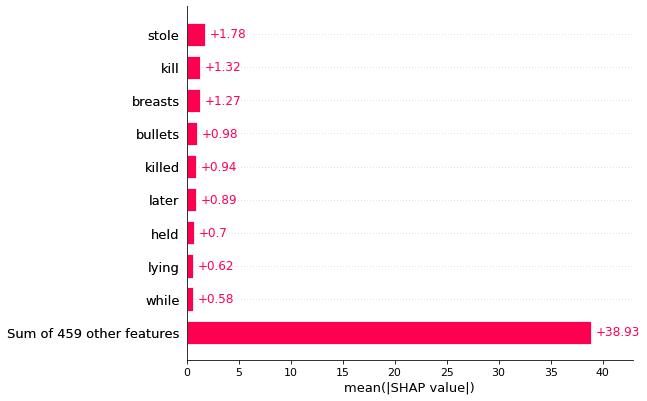

In [ ]:
shap.plots.bar(shap_values)

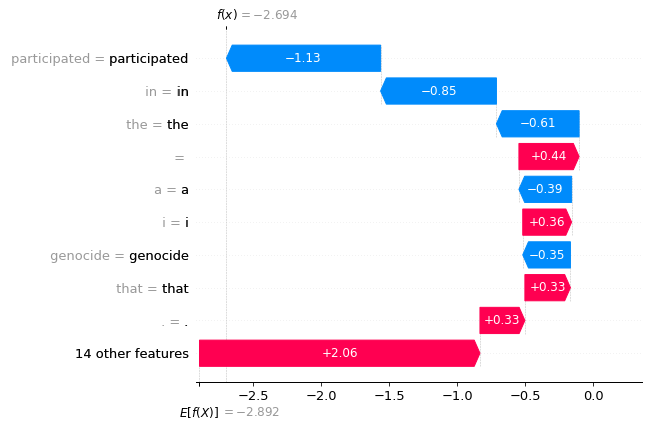

In [ ]:
shap.plots.waterfall(shap_values[0])

# Missclassifications

In [ ]:
ground_truth = df_dataset[df_dataset["role"]=="Witness"][COL_OF_INTEREST]
list_sentences = df_dataset[df_dataset["role"]=="Witness"][COL_OF_REFERENCE]

seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)


all_spans_tokenized = mlclassif_utilities.get_all_spans_tokenized(
        tokenizer,
        list_sentences,
        _add_special_tokens = ADD_SPECIAL_TOKENS, 
        _max_length = MAX_LENGTH_EMBEDDING,
        _pad_to_max_length = PAD_TO_MAX_LENGTH,
        _return_attention_mask = RETURN_ATTENTION_MASK, 
        type_tensors = "pt"
    )

input_ids = mlclassif_utilities.convert_list_into_pytorch_tensor(all_spans_tokenized[0])
attention_masks = mlclassif_utilities.convert_list_into_pytorch_tensor(all_spans_tokenized[1])
numeric_classes = mlclassif_utilities.convert_list_labels_into_pytorch_tensor(list(ground_truth))

input_ids = input_ids.to(device)
attention_masks = attention_masks.to(device)
numeric_classes = numeric_classes.to(device)

dataset = mlclassif_utilities.create_tensor_dataset(input_ids, attention_masks, numeric_classes)
dataloader = mlclassif_utilities.create_dataloader(dataset, BATCH_SIZE)

def predict(model, device, dataloader):
    #return model(inputs)[0]
    predictions = list()
    model.eval()

    for batch in dataloader:
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        with torch.no_grad():
            result = model(b_input_ids, 
                          token_type_ids=None, 
                          attention_mask=b_input_mask,
                          labels=b_labels,
                          return_dict=True)
        loss = result.loss
        logits = result.logits

        predictions.extend(logits.argmax(dim=1).cpu().numpy())
    return predictions

predictions = predict(model, device, dataloader)

In [ ]:
list_indices = list()
list_ground_truth = list()
list_predictions = list()
list_text_sentences = list()
list_sentences_2 = list(list_sentences)
for index, (true, prediction) in enumerate(zip(ground_truth, predictions)):
  if true != prediction:
    list_ground_truth.append(true)
    list_predictions.append(prediction)
    list_text_sentences.append(list_sentences_2[index])
    list_indices.append(index)

print(len(list_indices))

In [ ]:
#json_info = {"ground_truth": list_ground_truth, "predictions": list_predictions, "text": list_text_sentences}
#df_info = pd.DataFrame.from_dict(json_info).reset_index()
#df_info.to_excel("MisclassificationsHB-contrainedDS-DS07022023-withCV.xlsx")